In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.utils.data_utils import Sequence
import keras
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split



from albumentations import (
    HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate
)

import cv2
import random, math
import zipfile

import pandas as pd
import os

Using TensorFlow backend.


In [2]:
zipfiles = ['train','test','train_cleaned']

for each_zip in zipfiles:
    with zipfile.ZipFile("../input/denoising-dirty-documents/"+each_zip+".zip","r") as z:
        z.extractall(".")

In [3]:
train_files = sorted(glob("/kaggle/working/train/*.png"))
train_cleaned_files = sorted(glob("/kaggle/working/train_cleaned/*.png"))
test_files = sorted(glob("/kaggle/working/test/*.png"))


test =[]
for file in test_files:
    timg = load_img(file, color_mode="grayscale", target_size=(420,540))
    timg = img_to_array(timg)/255.
    test.append(timg)

len(train_files), len(train_cleaned_files), len(test_files)

(144, 144, 72)

In [4]:
class Daugmentation:
    

    def flip(img, t):
        if t[0]==0:
            return img
        else:
            return cv2.flip(img, t[1])

    def zoom(img, t):
        if t[2]==0:
            return img
        else:
            h, w = img.shape[:2]
            nh, nw =  int(t[3]*h), int(t[3]*w)
            dh, dw = h-nh, w-nw
            zimg = img[dh//2:nh+dh//2, dw//2:nw+dw//2]
            zimg = cv2.resize(zimg, (w,h))
            return zimg


    def get_ts(batch_size):
        return [[random.choice([0,1]),random.choice([-1,0,1]), random.randint(0,2),random.uniform(0.4,0.9)] for i in range(batch_size)]

    def aug(img,t):
        img = Daugmentation.flip(img,t)
        img = Daugmentation.zoom(img, t)
        img = cv2.resize(img, (540,420))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img/255.
        img = img.reshape(420,540,1)
        return img


class maSequence(Sequence):
    def __init__(self, x_set, y_set, batch_size, Daugmentation):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augment = Daugmentation

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        ts = self.augment.get_ts(len(batch_x))
        return np.array([self.augment.aug(x,t) for x,t in zip(batch_x,ts)]),np.array([self.augment.aug(y,t) for y,t in zip(batch_y,ts)]) 

In [5]:
X = []
Y = []
test = []
for i in zip(train_files, train_cleaned_files):
    page = cv2.imread(i[0])
    X.append(page)
    page = cv2.imread(i[1])
    Y.append(page)

for i in test_files:
    page = cv2.imread(i)
    test.append(page)

X = np.array(X)
Y = np.array(Y)
test = np.array(test)

x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.1)
x_train.shape,y_train.shape, x_test.shape, y_test.shape

((129,), (129,), (15,), (15,))

In [6]:
batch_size=8

gotrain = maSequence(x_train, y_train, batch_size,Daugmentation)
gotest = maSequence(x_test, y_test, batch_size,Daugmentation)


In [7]:
def get_model():
    # encoder
    In = Input(shape=(420,540,1))
    x = Conv2D(32,(3,3),padding="same",activation="relu")(In)
    x = BatchNormalization()(x)
    
    x = MaxPooling2D((2,2), padding="same")(x)
    x = Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x = Conv2D(64,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    x = MaxPooling2D((2,2), padding="same")(x)
    x = Conv2D(64,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(128,(2,2),activation="relu")(x)
    x = Dropout(0.25)(x)
    
    x = MaxPooling2D((2,2), padding="same")(x)
    x = Conv2D(128,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(256,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x) 
    x = Dropout(0.25)(x)
    
    # decoder
    x = Conv2D(256,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(128,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(128, (2,2), activation="relu")(x)
    x = BatchNormalization()(x) 
    x = Conv2D(64,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    x = UpSampling2D((2,2))(x)
    x = Conv2D(64,(3,3), padding="same",activation="relu")(x)
    x = Conv2D(32,(3,3), padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    
    x = UpSampling2D((2,2))(x)
    x = Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    
    Out = Conv2D(1,(3,3), padding="same",activation="sigmoid")(x)
    
    model = Model(In,Out)
    model.compile(optimizer="adam",loss="binary_crossentropy")
    return model

model = get_model()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 420, 540, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 420, 540, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 420, 540, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 210, 270, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 210, 270, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 210, 270, 64)      18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 210, 270, 64)      256 

In [8]:
checkpointer = ModelCheckpoint(filepath='best.h5', verbose=1, save_best_only=True)
history = model.fit_generator(generator=gotrain,
                              steps_per_epoch=gotrain.__len__(),
                              epochs=2000,
                              verbose=1,
                              callbacks=[checkpointer],
                              validation_data=gotest,
                              validation_steps=gotest.__len__())


Epoch 1/2000
17/17 [==============================] - 14s 828ms/step - loss: 0.6831 - val_loss: 0.6007

Epoch 00001: val_loss improved from inf to 0.60070, saving model to best.h5
Epoch 2/2000
17/17 [==============================] - 5s 271ms/step - loss: 0.5877 - val_loss: 0.5146

Epoch 00002: val_loss improved from 0.60070 to 0.51463, saving model to best.h5
Epoch 3/2000
17/17 [==============================] - 5s 275ms/step - loss: 0.4978 - val_loss: 0.4101

Epoch 00003: val_loss improved from 0.51463 to 0.41011, saving model to best.h5
Epoch 4/2000
17/17 [==============================] - 5s 274ms/step - loss: 0.3836 - val_loss: 0.3497

Epoch 00004: val_loss improved from 0.41011 to 0.34969, saving model to best.h5
Epoch 5/2000
17/17 [==============================] - 5s 279ms/step - loss: 0.2906 - val_loss: 0.3478

Epoch 00005: val_loss improved from 0.34969 to 0.34779, saving model to best.h5
Epoch 6/2000
17/17 [==============================] - 5s 276ms/step - loss: 0.2428 - val

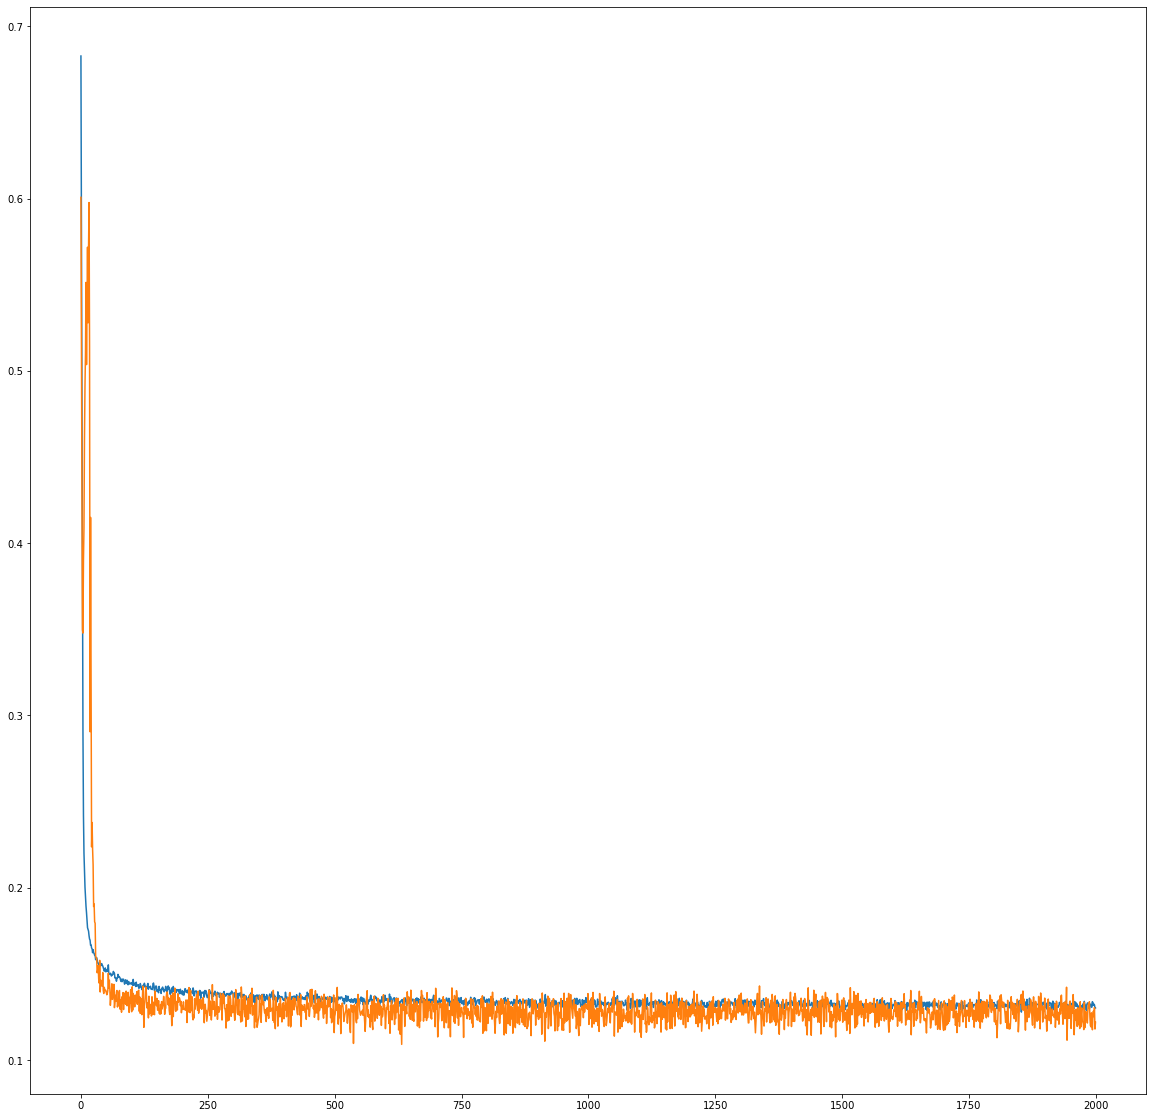

In [9]:
plt.figure(figsize=(20,20))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [10]:
test = []
for file in test_files:
    img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (540,420))/255.
    img = img.reshape(420,540,1)
    test.append(img)
    
test = np.array(test)
test.shape

(72, 420, 540, 1)

In [11]:
pred = model.predict([[test[13]]])

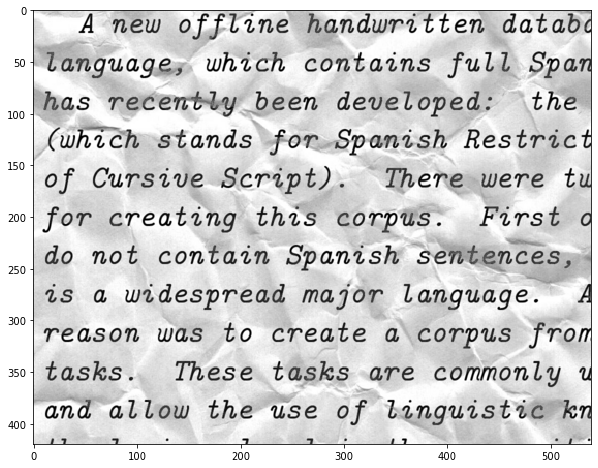

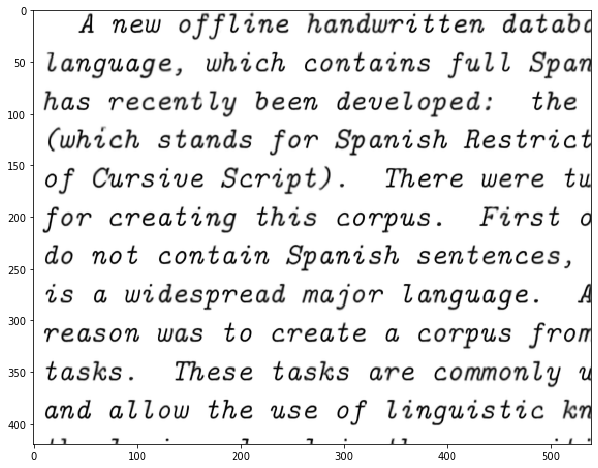

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(test[13].reshape(420,540),"gray")
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(pred.reshape(420,540),"gray")
plt.show()

In [13]:
def eval_model(test_images):
    preds = model.predict([test_images])
    return preds

preds = eval_model(test)
preds_denormalized  = np.array([(i*255.0) for i in preds])
preds_denormalized.shape



(72, 420, 540, 1)

In [14]:





preds = preds.reshape(-1, 420, 540)
test_dir="test"

TEST_IMAGES = os.listdir(test_dir)
ids = []
vals = []
for i, f in enumerate(TEST_IMAGES):
    imgid = int(f.split('.')[0])
    test_img = cv2.imread(os.path.join(test_dir,f), 0)
    img_shape = test_img.shape
    print('processing: {}'.format(imgid))
    print(img_shape)
    preds_reshaped = cv2.resize(preds[i], (img_shape[1], img_shape[0]))
    for r in range(img_shape[0]):
        for c in range(img_shape[1]):
            ids.append(str(imgid)+'_'+str(r + 1)+'_'+str(c + 1))
            vals.append(preds_reshaped[r, c])

print('Writing to csv file')
pd.DataFrame({'id': ids, 'value': vals}).to_csv('submission.csv', index=False)

len(vals)
my_submission = pd.read_csv("submission.csv")
my_submission.head()

processing: 205
(420, 540)
processing: 214
(420, 540)
processing: 112
(420, 540)
processing: 28
(258, 540)
processing: 34
(258, 540)
processing: 43
(258, 540)
processing: 160
(420, 540)
processing: 169
(420, 540)
processing: 118
(420, 540)
processing: 76
(420, 540)
processing: 64
(258, 540)
processing: 85
(420, 540)
processing: 190
(420, 540)
processing: 181
(420, 540)
processing: 193
(420, 540)
processing: 199
(420, 540)
processing: 52
(258, 540)
processing: 211
(420, 540)
processing: 7
(258, 540)
processing: 106
(420, 540)
processing: 37
(258, 540)
processing: 196
(420, 540)
processing: 109
(420, 540)
processing: 31
(258, 540)
processing: 88
(420, 540)
processing: 154
(420, 540)
processing: 13
(258, 540)
processing: 67
(258, 540)
processing: 142
(420, 540)
processing: 19
(258, 540)
processing: 145
(420, 540)
processing: 49
(258, 540)
processing: 94
(420, 540)
processing: 130
(420, 540)
processing: 82
(420, 540)
processing: 73
(420, 540)
processing: 157
(420, 540)
processing: 16
(258,

,id,value
0,205_1_1,0.986189
1,205_1_2,0.996289
2,205_1_3,0.998213
3,205_1_4,0.998457
4,205_1_5,0.998921
